# impact of k-means initialization

# 1. Import necessary libraries

In [71]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.utils import check_random_state, shuffle

random_state = np.random.RandomState(0)

# 2. Generate data for analysis

In [72]:
random_state = np.random.RandomState(0)

# Number of run (with randomly generated dataset) for each strategy so as
# to be able to compute an estimate of the standard deviation
n_runs = 5

# k-means models can do several random inits so as to be able to trade
# CPU time for convergence robustness
n_init_range = np.array([1, 5, 10, 15, 20])

# Datasets generation parameters
n_samples_per_center = 100
grid_size = 3
scale = 0.1
n_clusters = grid_size**2


def make_data(random_state, n_samples_per_center, grid_size, scale):
    random_state = check_random_state(random_state)
    centers = np.array([[i, j] for i in range(grid_size) for j in range(grid_size)])
    n_clusters_true, n_features = centers.shape

    noise = random_state.normal(
        scale=scale, size=(n_samples_per_center, centers.shape[1])
    )

    X = np.concatenate([c + noise for c in centers])
    y = np.concatenate([[i] * n_samples_per_center for i in range(n_clusters_true)])
    return shuffle(X, y, random_state=random_state)


In [74]:
pd.DataFrame(X)

,0,1
0,0.048401,-0.604313
1,-2.903776,-1.767621
2,0.760342,-1.217213
3,1.672033,0.708451
4,-0.614448,-0.583204
...,...,...
2995,-1.078711,-0.371495
2996,0.613998,-1.245051
2997,-0.631327,-1.397462
2998,-1.473124,-1.289252


# 3. Quantitative evaluation of various init methods

Evaluation of KMeans with k-means++ init
Evaluation of KMeans with random init
Evaluation of MiniBatchKMeans with k-means++ init
Evaluation of MiniBatchKMeans with random init


Text(0.5, 1.0, 'Mean inertia for various k-means init across 5 runs')

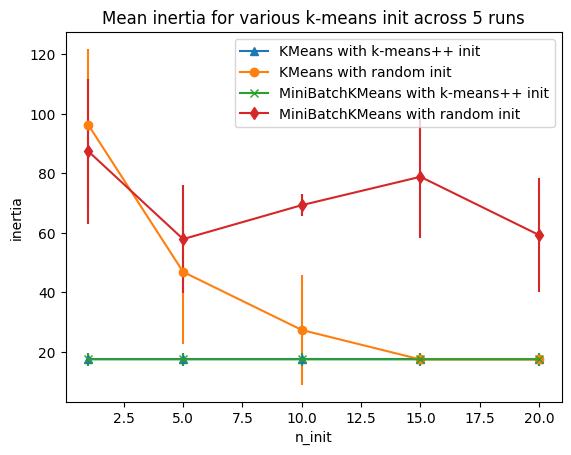

In [78]:
# Part 1: Quantitative evaluation of various init methods


plt.figure()
plots = []
legends = []

cases = [
    (KMeans, "k-means++", {}, "^-"),
    (KMeans, "random", {}, "o-"),
    (MiniBatchKMeans, "k-means++", {"max_no_improvement": 3}, "x-"),
    (MiniBatchKMeans, "random", {"max_no_improvement": 3, "init_size": 500}, "d-"),
]

for factory, init, params, format in cases:
    print("Evaluation of %s with %s init" % (factory.__name__, init))
    inertia = np.empty((len(n_init_range), n_runs))

    for run_id in range(n_runs):
        X, y = make_data(run_id, n_samples_per_center, grid_size, scale)
        for i, n_init in enumerate(n_init_range):
            km = factory(
                n_clusters=n_clusters,
                init=init,
                random_state=run_id,
                n_init=n_init,
                **params,
            ).fit(X)
            inertia[i, run_id] = km.inertia_
    p = plt.errorbar(
        n_init_range, inertia.mean(axis=1), inertia.std(axis=1), fmt=format
    )
    plots.append(p[0])
    legends.append("%s with %s init" % (factory.__name__, init))

plt.xlabel("n_init")
plt.ylabel("inertia")
plt.legend(plots, legends)
plt.title("Mean inertia for various k-means init across %d runs" % n_runs)

# 4. Qualitative visual inspection of the convergence

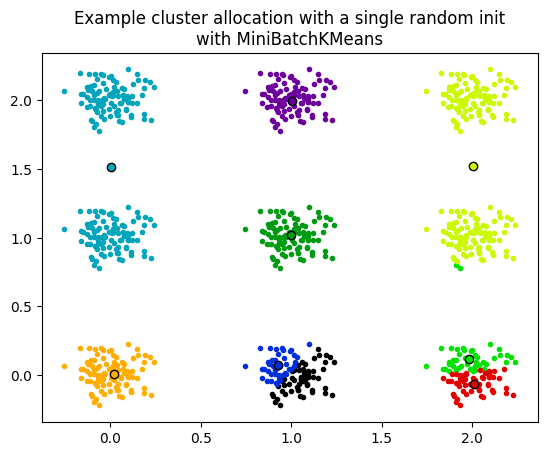

In [79]:
# Part 2: Qualitative visual inspection of the convergence

X, y = make_data(random_state, n_samples_per_center, grid_size, scale)
km = MiniBatchKMeans(
    n_clusters=n_clusters, init="random", n_init=1, random_state=random_state
).fit(X)

plt.figure()
for k in range(n_clusters):
    my_members = km.labels_ == k
    color = cm.nipy_spectral(float(k) / n_clusters, 1)
    plt.plot(X[my_members, 0], X[my_members, 1], ".", c=color)
    cluster_center = km.cluster_centers_[k]
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=color,
        markeredgecolor="k",
        markersize=6,
    )
    plt.title(
        "Example cluster allocation with a single random init\nwith MiniBatchKMeans"
    )

plt.show()

In summary, while K-Means often provides a more accurate solution, Mini-Batch K-Means offers a faster and more scalable alternative for large datasets. The choice between the two depends on the specific requirements of your application, including the size of the dataset, the desired accuracy, and the available computational resources.